In [61]:
from bokeh.plotting import output_notebook
output_notebook()

Loading BokehJS ...

# Monocrata

Our goal is to provide a simple interface, where we can control different Policies the government can take, and see the impact they have on different parts of our system. This is a toy model, which does NOT take into account the complexities of the real world. I hope this illuminates some of the trade-offs of some of these decisions.

## Implementation

- Inputs
    - `PolicySet`: The decisions available to the client.
    - `Person`: Description of an individual, for tax purposes. Contains the methods:
        - `random` to generate an individual following a sensible distribution.
        - `tax_burden` to calculate how much this person owns in taxes.
    - `PopulationSize`: Total number of individuals.
- Results:
    - `Budget`: The distribution of the available budget per sector, together with the yearly surplus/deficit.

## Code

The 2 classes below define inputs and outputs needed for this model

In [62]:
from dataclasses import dataclass
import numpy as np

@dataclass
class PolicySet:
    IMI: float = .1
    IRS: float = .23
    healthcare_budget: int = 20_000_000
    education_budget: int = 30_000_000

@dataclass
class Person:
    income: float
    
    def __init__(self): # Unrealistic model generating incomes used for testing purposes
        self.income = np.random.uniform(low=0, high=10_000)

    def tax_burden(self, policy_set: PolicySet) -> float: # total i.e. absolute tax_burden
        irs_total = policy_set.IRS * self.income
        imi_total = max(self.income-1_000,0) * policy_set.IMI
        return min(irs_total + imi_total, self.income) # unrealistic model used for testing purposes 

@dataclass
class Budget:
    total: int
    healthcare: int
    education: int
    
    @property
    def deficit(self):
        return self.total - sum([self.healthcare, self.education])

The simulator represents our model of how inputs map to results for our country. It calculates the tax_burden first. Then we use a Markov simulation to obtain the expected budget. Finally

In [63]:
from tqdm import tqdm

def national_budget_calculator(
        policy_set: PolicySet,
        population_size: int = 10_500_000
) -> Budget:
    tax_contribution_list = [
        Person().tax_burden(policy_set)
        for _
        in tqdm(range(min(population_size,10**5)))
    ]
    revenue = sum(tax_contribution_list)
    return Budget(
        total=revenue,
        healthcare=PolicySet.healthcare_budget,
        education=PolicySet.education_budget,
    )

# Visualized

We chose to use the default values for both policies and population distributions

In [64]:
budget = national_budget_calculator(policy_set=PolicySet())
budget

100%|██████████| 100000/100000 [00:00<00:00, 265033.53it/s]


Budget(total=156277856.95898357, healthcare=20000000, education=30000000)

## Tax burden

The plot below showcases the tax burden as a function of a person's income

100%|██████████| 100000/100000 [00:00<00:00, 221596.78it/s]


(0.0, 1.0)

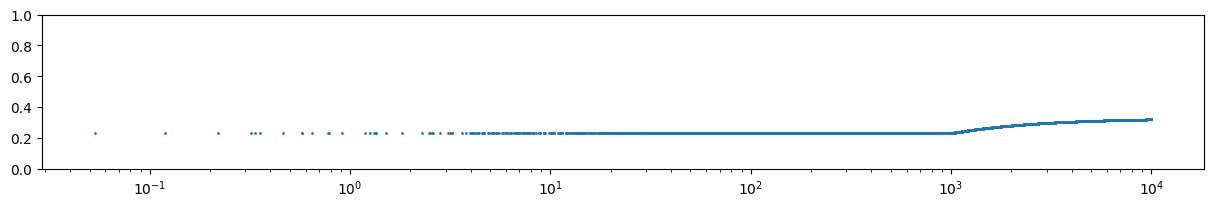

In [65]:
from matplotlib import pyplot as plt
ps = PolicySet()
observations = [
    (p.income, np.divide(p.tax_burden(ps), p.income))
     for p
     in [Person() for _ in tqdm(range(10**5))] 
]
[income_array, tax_burden_array] = list(zip(*observations))

# Plot
fig, ax = plt.subplots(figsize = (15,2))
ax.scatter(income_array, tax_burden_array, s=1)
ax.set_xscale("log")
ax.set_ylim(ymin=0, ymax=1)

## Budget

Summary of the expenses

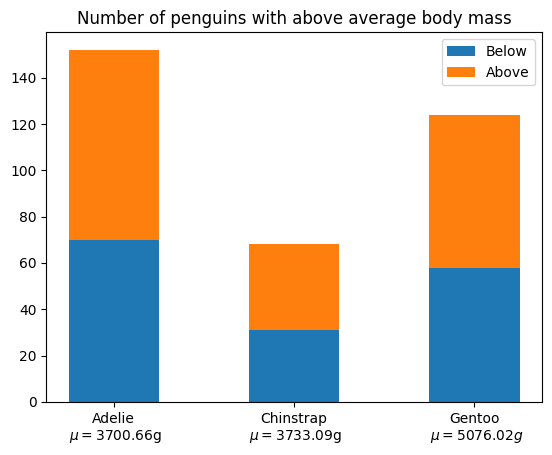

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# data from https://allisonhorst.github.io/palmerpenguins/

species = (
    "Adelie",
    "Chinstrap",
    "Gentoo",
)
weight_counts = {
    "Below": np.array([70, 31, 58]),
    "Above": np.array([82, 37, 66]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, budget_value in weight_counts.items():
    p = ax.bar(species, budget_value, width, label=boolean, bottom=bottom)
    bottom += budget_value

ax.set_title("Number of penguins with above average body mass")
ax.legend(loc="upper right")

plt.show()

100%|██████████| 100000/100000 [00:00<00:00, 469907.91it/s]


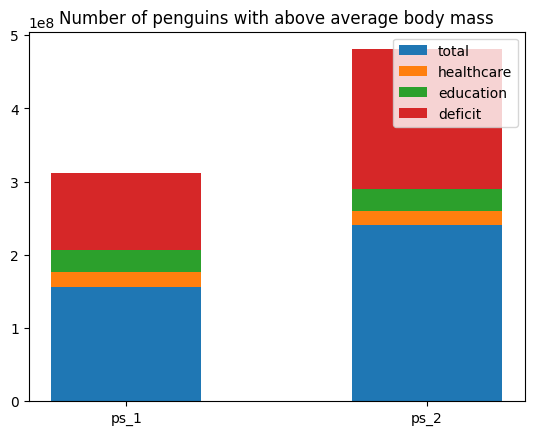

In [82]:
budget_1 = national_budget_calculator(policy_set=PolicySet())
budget_2 = national_budget_calculator(policy_set=PolicySet(IRS=.4))

policies = ["ps_1", "ps_2"]
columns = ["total", "healthcare", "education", "deficit"]

budget_as_dict = {
    c: [budget_1.__getattribute__(c), budget_2.__getattribute__(c)]
    for c in columns   
}

fig, ax = plt.subplots()
bottom = np.zeros(2)

for boolean, budget_value in budget_as_dict.items():
    p = ax.bar(policies, budget_value, width, label=boolean, bottom=bottom)
    bottom += budget_value

ax.set_title("Number of penguins with above average body mass")
ax.legend(loc="upper right")

plt.show()

# Unrelated

In [67]:
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, CustomJS, Slider
from bokeh.plotting import figure, show

x = np.linspace(0, 10, 500)
y = np.sin(x)

source = ColumnDataSource(data=dict(x=x, y=y))

plot = figure(y_range=(-10, 10), width=400, height=400)
plot.line('x', 'y', source=source, line_width=3, line_alpha=0.6)

amp = Slider(start=0.1, end=10, value=1, step=.1, title="Amplitude")
freq = Slider(start=0.1, end=10, value=1, step=.1, title="Frequency")
phase = Slider(start=-6.4, end=6.4, value=0, step=.1, title="Phase")
offset = Slider(start=-9, end=9, value=0, step=.1, title="Offset")

callback = CustomJS(
    args=dict(source=source, amp=amp, freq=freq, phase=phase, offset=offset),
    code="""
        const A = amp.value
        const k = freq.value
        const phi = phase.value
        const B = offset.value
    
        const x = source.data.x
        const y = Array.from(x, (x) => B + A*Math.sin(k*x+phi))
        source.data = { x, y }
        """
)

amp.js_on_change('value', callback)
freq.js_on_change('value', callback)
phase.js_on_change('value', callback)
offset.js_on_change('value', callback)

show(
    row(
        plot,
        column(amp, freq, phase, offset)
    )
)

In [68]:
from bokeh.plotting import figure, show

fruits = ['Apples', 'Pears', 'Nectarines', 'Plums', 'Grapes', 'Strawberries']
counts = [5, 3, 4, 2, 4, 6]

p = figure(
    x_range=fruits,
    height=350,
    title="Fruit Counts",
    toolbar_location=None,
    tools=""
)

p.vbar(
    x=fruits,
    top=counts,
    width=0.9
)

p.xgrid.grid_line_color = None
p.y_range.start = 0

show(p)
